In [1]:
import numpy as np
import pandas as pd
pd.set_option('precision', 3)
from itertools import compress
import copy, sys, os
import matplotlib.pyplot as plt
from pyirr import intraclass_correlation
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold, RepeatedStratifiedKFold, permutation_test_score, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, confusion_matrix, make_scorer
from scipy.stats import spearmanr, mannwhitneyu

oldPath = os.path.join(os.path.expanduser('~'), 'Documents/GitHub/icrpythonradiomics/machineLearning')
if os.path.exists(oldPath):
    sys.path.remove(oldPath)
sys.path.append(os.path.join(os.path.expanduser('~'), 'Documents/git/git_icrpythonradiomics/machineLearning'))
from featureSelection import featureSelection_correlation

# validation parameters
n_splits = 10
n_repeats = 100
n_permutations = 2


In [2]:
def roc_curve_thresholds(yTrue, yScore, thresholds):
    tnArr, fpArr, fnArr, tpArr = [], [], [], []
    nSamples = len(yTrue)
    for thresh in thresholds:
        tn, fp, fn, tp = confusion_matrix(yTrue, yScore>thresh).ravel()
        tnArr.append(tn/nSamples)
        fpArr.append(fp/nSamples)
        fnArr.append(fn/nSamples)
        tpArr.append(tp/nSamples)
    return np.array(tnArr), np.array(fpArr), np.array(fnArr), np.array(tpArr)

In [3]:
def calculate_fnr(y_true, y_pred, pt=0):

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred > pt).ravel()
    return fn/(fn + tp)

def calculate_fpr(y_true, y_pred, pt=0):

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred > pt).ravel()
    return fp/(fp + tn)

def unpack_scorers(cvr):

    thresh_FNR, thresh_FPR, value_FNR, value_FPR = [], [], [], []
    
    for key, value in cvr.items():
        if 'test_FNR' in key:
            thresh_FNR.append(float(key.replace('test_FNR_','')))
            value_FNR.append(np.mean(value))
        if 'test_FPR' in key:
            thresh_FPR.append(float(key.replace('test_FPR_','')))
            value_FPR.append(np.mean(value))

    idxFNR = np.argsort(thresh_FNR)
    idxFPR = np.argsort(thresh_FPR)

    FNR = {'thresholds': [thresh_FNR[idx] for idx in idxFNR],
           'values': [value_FNR[idx] for idx in idxFNR]}
    
    FPR = {'thresholds': [thresh_FPR[idx] for idx in idxFPR],
           'values': [value_FPR[idx] for idx in idxFPR]}
    
    return FNR, FPR

# Make dictionary of scorers, each of which will compute one point on the FNR and FPR curves.
# The dictionary key is used to keep track of the threshold value that was used.
scorers = {}

# Don't use 0 and 1 as endpoints as this causes numerical underflow.
ptArr = np.round(np.linspace(0, 1, 501),2)
ptArr[0] = np.round(0.0001,4)
ptArr[-1] = np.round(0.9999,4)

for pt in ptArr:
    scorers['FNR_' + str(pt)] = make_scorer(calculate_fnr, pt = pt, needs_proba=True)
    scorers['FPR_' + str(pt)] = make_scorer(calculate_fpr, pt = pt, needs_proba=True)

# standard scorers    
scorers['roc_auc'] = 'roc_auc'
scorers['accuracy'] = 'accuracy'
scorers['f1'] = 'f1'

In [4]:
# load two reader data - for ICC

twoReaderFile = os.path.join(os.path.expanduser('~'), 'Dropbox (ICR)/CLINMAG/Radiomics/ECE_Prostate_Semantic/ECE_Semantic_Data/GG_MG.xlsx')

# read spreadsheet
df = pd.read_excel(twoReaderFile, sheet_name='GG_MG', engine='openpyxl')

# remove features, as with the discovery/test data
df.drop(['IndexLesion_GG', 'IndexLesionMG', 'GlobalStageGG', 'GlobalStageMG'], axis=1, inplace=True)

# remove rows with missing data - need to check that this leaves the same patients for dfGG as in the discovery data set
df.dropna(inplace=True)

# split to each reader
dfGG = df.filter(regex = 'GG|PID', axis = 1)
dfMG = df.filter(regex='MG|PID', axis=1)

# match column names by removing subscripts
dfGG = dfGG.rename(columns=lambda x: x.replace('_GG','').replace('GG',''))
dfMG = dfMG.rename(columns=lambda x: x.replace('_MG','').replace('MG',''))

# change some column names to match the discovery/test data sets
renameDict = {'LocIndexL':'AnatDev01',
              'LocAnat':'AnatDev02',
              'Division':'AnatDev03',
              'DivisionLat':'AnatDev04',
              'LesionSize':'MajorLengthIndex',
              'SmoothCapsularBulgin':'SmoothCapsularBulging',
              'UnsharpMargins':'UnsharpMargin',
              'irregularContour':'IrregularContour',
              'BlackEstrition':'BlackEstritionPeripFat',
              'measurableECE':'MeasurableECE',
              'retroprostaticAngleObl':'RetroprostaticAngleOblit'}
dfGG.rename(renameDict, axis=1, inplace=True)
dfMG.rename(renameDict, axis=1, inplace=True)

# highsignalT1FS is missing from this spreadsheet, so fill in with default value.
# Fortunately, this feature is not selected in the final model, but we need it there for compatibility.
dfGG.loc[:, 'highsignalT1FS'] = 0
dfMG.loc[:, 'highsignalT1FS'] = 0

iccDict = {}
for col in dfGG.drop(['PID', 'highsignalT1FS'], axis=1):
    data = np.stack((dfGG[col], dfMG[col]), axis=1)
    iccDict['semantic_' + col] = intraclass_correlation(data, "twoway", "agreement").value

In [5]:
radiomicsFile = os.path.join(os.path.expanduser('~'), 'Dropbox (ICR)/CLINMAG/Radiomics/ECE_Prostate_Semantic/ECE_Semantic_Data/radiomicFeatures.csv')

dfRad = pd.read_csv(radiomicsFile)
dfRad.drop(list(dfRad.filter(regex = 'source')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'diagnostics')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'histogram')), axis = 1, inplace = True)

# To match the semantic data file
dfRad['StudyPatientName'] = dfRad['StudyPatientName'].str.replace('_',' ')

# sensible prefix 
dfRad = dfRad.rename(columns=lambda x: x.replace('original','radiomics'))

# split off the repro rows
dfRep1 = dfRad.loc[dfRad.StudyPatientName.str.contains('rep'),:].copy()
dfRep1['StudyPatientName'] = dfRep1['StudyPatientName'].str.replace(' repro','')
dfRep1.sort_values('StudyPatientName', axis=0, inplace=True)
dfRep1.reset_index(inplace=True, drop=True)

# remove repro from main data frame
dfRad = dfRad.loc[~dfRad.StudyPatientName.str.contains('rep'),:]
dfRad.reset_index(inplace=True, drop=True)

# main data rows for same patients as repro
dfRep0 = dfRad.loc[dfRad['StudyPatientName'].isin(dfRep1['StudyPatientName'])].copy()
dfRep0.sort_values('StudyPatientName', axis=0, inplace=True)
dfRep0.reset_index(inplace=True, drop=True)

for col in dfRep1.drop('StudyPatientName', axis=1):
    data = np.stack((dfRep0[col], dfRep1[col]), axis=1)
    iccDict[col] = intraclass_correlation(data, "twoway", "agreement").value


In [6]:
discoveryFile = os.path.join(os.path.expanduser('~'), 'Dropbox (ICR)/CLINMAG/Radiomics/ECE_Prostate_Semantic/ECE_Semantic_Data/discovery.csv')
externalTestFile = os.path.join(os.path.expanduser('~'), 'Dropbox (ICR)/CLINMAG/Radiomics/ECE_Prostate_Semantic/ECE_Semantic_Data/external.csv')
    
# load data
dfTrain = pd.read_csv(discoveryFile)
dfTest  = pd.read_csv(externalTestFile)

# drop features we are not going to use for classification
dfTrain.drop(['Gleason biopsy','TumorGradeMRI'], inplace=True, axis=1)
dfTest.drop(['Gleason biopsy','TumorGradeMRI'], inplace=True, axis=1)

# make these features binary 0/1
toBinary = ['SmoothCapsularBulging' ,'CapsularDisruption', 'UnsharpMargin', 'IrregularContour', 'BlackEstritionPeripFat', 'MeasurableECE', 'RetroprostaticAngleOblit', 'highsignalT1FS']
for tb in toBinary:
    dfTrain[tb]  = dfTrain[tb].map(dict(YES=1, NO=0))
    dfTest[tb] = dfTest[tb].map(dict(YES=1, NO=0))

# is missing in test and training, so replace both with median from the training data
psaTrainMedian = np.nanmedian(np.array(dfTrain.PSA))
dfTrain.PSA.fillna(psaTrainMedian, inplace=True)
dfTest.PSA.fillna(psaTrainMedian, inplace=True)

# this feature is not selected in the semantic model, so this has no effect
# fill in with the most common value
dfTest.highsignalT1FS.fillna(0, inplace=True)

# add string to names for easy manipulation of groups
clinicalFeatures = ['GleasonBinary', 'ProstateVolume', 'PSA', 'IndLesPIRADS_V2']
semanticFeatures = list(set(dfTrain.columns) - set(clinicalFeatures) - set(['PID', 'ECE_Pathology']))
dfTrain = dfTrain.rename(columns=lambda x: 'clinical_' + x if x in clinicalFeatures else x)
dfTest = dfTest.rename(columns=lambda x: 'clinical_' + x if x in clinicalFeatures else x)
dfTrain = dfTrain.rename(columns=lambda x: 'semantic_' + x if x in semanticFeatures else x)
dfTest = dfTest.rename(columns=lambda x: 'semantic_' + x if x in semanticFeatures else x)

# merge radiomics 
dfTrain = dfTrain.merge(dfRad, left_on='PID', right_on='StudyPatientName')
dfTest = dfTest.merge(dfRad, left_on='PID', right_on='StudyPatientName')
dfTrain = dfTrain.drop(['PID', 'StudyPatientName'], axis=1)
dfTest = dfTest.drop(['PID', 'StudyPatientName'], axis=1)

# prediction target
yTrain = np.array(dfTrain.ECE_Pathology)
yTest = np.array(dfTest.ECE_Pathology)


# Baseline model using only clinical features

In [7]:
def fitClinical(displayCoef=False):
    
    print('\nBaseline model using only clinical features\n')

    # reproducible execution
    seed = 42
    np.random.seed(seed)

    # get training and test data
    XTrain = dfTrain.drop('ECE_Pathology', axis=1)
    XTest = dfTest.drop('ECE_Pathology', axis=1)

    XTrain.drop(list(XTrain.filter(regex = 'semantic|radiomic')), axis = 1, inplace = True)
    XTest.drop(list(XTest.filter(regex = 'semantic|radiomic')), axis = 1, inplace = True)

    # logistic LASSO tuning parameter optimised using function with in-built CV
    pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lr', LogisticRegression(penalty='none'))])

    # fit to all data
    pipeline.fit(XTrain, yTrain)

    # cross-validate
    outer_cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    cv_result = cross_validate(pipeline, X=XTrain, y=yTrain, cv=outer_cv, scoring=scorers,
                               return_estimator=True, verbose=0, n_jobs=-1)

    FNR, FPR = unpack_scorers(cv_result)

    # print CV scores
    AUC_CV = np.mean(cv_result['test_roc_auc'])
    print('AUCROC   (CV) = ' + str(AUC_CV.round(3)))
    print('Accuracy (CV)  = ' + str(np.mean(cv_result['test_accuracy']).round(3)))
    print('F1       (CV)  = ' + str(np.mean(cv_result['test_f1']).round(3)))

    # permutation testing
    outer_cv.n_repeats = 1
    scoreDirect, perm_scores, pValueDirect = permutation_test_score(pipeline, XTrain, yTrain, scoring="roc_auc",
                                                                    cv=outer_cv, n_permutations=n_permutations,
                                                                    verbose=0, n_jobs=-1)

    # pValueDirect is computed using scoreDirect and assumes only one outer CV run
    # We have used repeated outer CV, so the following code correctly computes the p-value of our repeated CV performance estimate
    # Actually, it doesn't seem to make much difference, so am relaxed about that.

    p_values = []
    scores_roc_auc = np.mean(np.reshape(cv_result['test_roc_auc'], (n_repeats, -1)), axis=1)
    for score in scores_roc_auc:
        p_values.append((np.count_nonzero(perm_scores >= score) + 1) / (n_permutations + 1))
    print('p-value  (CV) = ' + str(np.mean(p_values).round(4)) + '\n')

    # get scores and predicted class info
    y_pred_score_test = pipeline.predict_proba(XTest)[:, 1]
    y_pred_class_test = pipeline.predict(XTest)

    # test scores from main model
    testAUROC = roc_auc_score(yTest, y_pred_score_test)
    testAccuracy = accuracy_score(yTest, y_pred_class_test)
    testF1 = f1_score(yTest, y_pred_class_test)

    pValueTest = mannwhitneyu(y_pred_score_test[yTest==0], y_pred_score_test[yTest==1]).pvalue

    # print the test performance metrics
    print('AUCROC   (test) = ' + str(np.round(testAUROC,3)))
    print('Accuracy (test) = ' + str(np.round(testAccuracy,3)))
    print('F1       (test) = ' + str(np.round(testF1,3)))
    print('p-value  (test) = ' + str(np.round(pValueTest, 6)) + '\n')

    # show coefficients
    if displayCoef:
        display(pd.DataFrame({'Feature':[x.replace('clinical_','') for x in XTrain.columns], 'Coefficient':np.squeeze(pipeline._final_estimator.coef_)}).style.hide_index())

    return AUC_CV, y_pred_score_test, y_pred_class_test, FNR, FPR


# Clinical + Semantic model

In [8]:
def fitClinicalSemantic(displayCoef=False, permutationTest=False):

    print('\n\n\nModel using clinical and semantic features\n')

    # reproducible execution
    seed = 42
    np.random.seed(seed)

    # get training and test data
    XTrain = dfTrain.drop('ECE_Pathology', axis=1)
    XTest = dfTest.drop('ECE_Pathology', axis=1)

    XTrain.drop(list(XTrain.filter(regex = 'radiomic')), axis = 1, inplace = True)
    XTest.drop(list(XTest.filter(regex = 'radiomic')), axis = 1, inplace = True)

    # logistic LASSO tuning parameter optimised using function with in-built CV
    pipeline = Pipeline(steps=[('scaler', StandardScaler()), 
                                       ('logistic',LogisticRegressionCV(Cs=20, 
                                                                        cv=10, 
                                                                        solver="liblinear",
                                                                        max_iter=10000, penalty='l1',
                                                                        random_state=seed,
                                                                        n_jobs=1))])

    # fit to all data
    pipeline.fit(XTrain, yTrain)


    # cross-validate
    outer_cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    cv_result = cross_validate(pipeline, X=XTrain, y=yTrain, cv=outer_cv, scoring=scorers,
                               return_estimator=True, verbose=0, n_jobs=-1)

    FNR, FPR = unpack_scorers(cv_result)

    # get frequency that features are non-zero across the repeated cv splits
    coef_cv = np.zeros((len(cv_result['estimator']), XTrain.shape[1]))
    for n, res in enumerate(cv_result['estimator']):
        coef_cv[n, :] = res._final_estimator.coef_
    coef_freq = np.sum(coef_cv != 0, axis=0) / (n_repeats * n_splits)

    # put icc values in array for including in DataFrame
    iccList = []
    for feat in XTrain.columns:
        if feat in iccDict:
            iccList.append(iccDict[feat])
        else:
            iccList.append('-')

    # display sorted coefficients and selection frequency
    coeffs = np.squeeze(pipeline._final_estimator.coef_)
    dfCoefResults = pd.DataFrame({'Feature': XTrain.columns, 'Coeff': coeffs, 'Freq': coef_freq, 'ICC':iccList})
    dfCoefResults.sort_values(by=['Coeff', 'Freq'], key=abs, inplace=True, ascending=False)

    # print CV scores
    AUC_CV = np.mean(cv_result['test_roc_auc'])
    print('AUCROC   (CV) = ' + str(AUC_CV.round(3)))
    print('Accuracy (CV) = ' + str(np.mean(cv_result['test_accuracy']).round(3)))
    print('F1       (CV) = ' + str(np.mean(cv_result['test_f1']).round(3)))

    # permutation testing
    if permutationTest:
        outer_cv.n_repeats = 1
        scoreDirect, perm_scores, pValueDirect = permutation_test_score(pipeline, XTrain, yTrain, scoring="roc_auc",
                                                                        cv=outer_cv, n_permutations=n_permutations,
                                                                        verbose=0, n_jobs=-1)

        # pValueDirect is computed using scoreDirect and assumes only one outer CV run
        # We have used repeated outer CV, so the following code correctly computes the p-value of our repeated CV performance estimate
        # Actually, it doesn't seem to make much difference, so am relaxed about that.

        p_values = []
        scores_roc_auc = np.mean(np.reshape(cv_result['test_roc_auc'], (n_repeats, -1)), axis=1)
        for score in scores_roc_auc:
            p_values.append((np.count_nonzero(perm_scores >= score) + 1) / (n_permutations + 1))
        print('p-value  (CV) = ' + str(np.mean(p_values).round(4)))

    # get scores and predicted class info
    y_pred_score_test = pipeline.predict_proba(XTest)[:, 1]
    y_pred_class_test = pipeline.predict(XTest)

    # test scores from main model
    testAUROC = roc_auc_score(yTest, y_pred_score_test)
    testAccuracy = accuracy_score(yTest, y_pred_class_test)
    testF1 = f1_score(yTest, y_pred_class_test)

    pValueTest = mannwhitneyu(y_pred_score_test[yTest==0], y_pred_score_test[yTest==1]).pvalue

    # print the test performance metrics
    print('\nAUCROC   (test) = ' + str(np.round(testAUROC,3)))
    print('Accuracy (test) = ' + str(np.round(testAccuracy,3)))
    print('F1       (test) = ' + str(np.round(testF1,3)))
    print('p-value  (test) = ' + str(np.round(pValueTest, 6)) + '\n')

    dfCoefResultsDisp = dfCoefResults.loc[dfCoefResults.Coeff != 0, :]
    if displayCoef:
        display(dfCoefResultsDisp.style.hide_index())

    return AUC_CV, y_pred_score_test, y_pred_class_test, FNR, FPR


# Clinical and radiomics model (no semantic features)

In [9]:
def fitClinicalRadiomic(displayCoef=False, dropRegex=None, permutationTest=False):

    print('\n\n\nModel using clinical and radiomic features\n')

    # reproducible execution
    seed = 42
    np.random.seed(seed)

    # get training and test data
    XTrain = dfTrain.drop('ECE_Pathology', axis=1)
    XTest = dfTest.drop('ECE_Pathology', axis=1)

    # drop some features
    XTrain.drop(list(XTrain.filter(regex = 'semantic')), axis = 1, inplace = True)
    XTest.drop(list(XTest.filter(regex = 'semantic')), axis = 1, inplace = True)
    if dropRegex is not None:
        XTrain.drop(list(XTrain.filter(regex = dropRegex)), axis = 1, inplace = True)
        XTest.drop(list(XTest.filter(regex = dropRegex)), axis = 1, inplace = True)
    
    # drop low variance features
    CoV = pd.DataFrame(XTrain.apply(lambda x: np.std(x)/np.mean(x), axis=0))
    lowVarianceFeatures = CoV.loc[CoV.loc[:,0]<0.01,:].index.values.tolist()
    XTrain.drop(lowVarianceFeatures, axis = 1, inplace = True)
    XTest.drop(lowVarianceFeatures, axis = 1, inplace = True)

    # make sure the clinical features are not removed by the correlation step
    namedColumnsKeep = [x for x in XTrain.columns if 'clinical' in x]

    correlationHierarchy = ['shape_MeshVolume', 'shape', 'firstorder']

    model = LogisticRegression(solver="liblinear", max_iter=10000, penalty='l1')
    C_grid = np.logspace(np.log10(0.05), np.log10(50), 10)
    inner_cv = StratifiedKFold(n_splits=5)
    modelOpt = GridSearchCV(estimator=model, param_grid={'C':C_grid}, cv=inner_cv, refit=True, verbose=0, scoring='neg_log_loss', n_jobs=1)

    pipeline = Pipeline([('correlationSelector', featureSelection_correlation(threshold=0.9,
                                                                                      exact=False,
                                                                                      featureGroupHierarchy=correlationHierarchy)),
                                 ('scaler', StandardScaler()),
                                 ('lr', modelOpt)])

    # fit to all data
    pipeline.fit(XTrain, yTrain)

    # cross-validate
    outer_cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    cv_result = cross_validate(pipeline, X=XTrain, y=yTrain, cv=outer_cv, scoring=scorers,
                               return_estimator=True, verbose=0, n_jobs=-1)

    FNR, FPR = unpack_scorers(cv_result)

    # get frequency that features are non-zero across the repeated cv splits
    coef_cv = np.zeros((len(cv_result['estimator']), XTrain.shape[1]))
    fs_mask = np.zeros((len(cv_result['estimator']), XTrain.shape[1]))
    for n, res in enumerate(cv_result['estimator']):
        fs_mask[n, :] = res.steps[0][1].mask_
        coef_cv[n, res.steps[0][1].mask_] = res._final_estimator.best_estimator_.coef_
    coef_freq = np.sum(coef_cv != 0, axis=0) / (n_repeats * n_splits)

    # put icc values in array for including in DataFrame
    iccList = []
    for feat in XTrain.columns:
        if feat in iccDict:
            iccList.append(iccDict[feat])
        else:
            iccList.append('-')

    # display sorted coefficients and selection frequency
    coeffs = np.zeros(XTrain.shape[1])
    coeffs[pipeline.steps[0][1].mask_] = np.squeeze(pipeline._final_estimator.best_estimator_.coef_)

    dfCoefResults = pd.DataFrame({'Feature': XTrain.columns, 'Coeff': coeffs, 'Freq': coef_freq, 'ICC':iccList})
    dfCoefResults.sort_values(by=['Coeff', 'Freq'], key=abs, inplace=True, ascending=False)

    # print CV scores
    AUC_CV = np.mean(cv_result['test_roc_auc'])
    print('AUCROC   (CV) = ' + str(AUC_CV.round(3)))
    print('Accuracy (CV) = ' + str(np.mean(cv_result['test_accuracy']).round(3)))
    print('F1       (CV) = ' + str(np.mean(cv_result['test_f1']).round(3)))

    # permutation testing
    if permutationTest:
        outer_cv.n_repeats = 1
        scoreDirect, perm_scores, pValueDirect = permutation_test_score(pipeline, XTrain, yTrain, scoring="roc_auc",
                                                                        cv=outer_cv, n_permutations=n_permutations,
                                                                        verbose=0, n_jobs=n_jobs)

        # pValueDirect is computed using scoreDirect and assumes only one outer CV run
        # We have used repeated outer CV, so the following code correctly computes the p-value of our repeated CV performance estimate
        # Actually, it doesn't seem to make much difference, so am relaxed about that.

        p_values = []
        scores_roc_auc = np.mean(np.reshape(cv_result['test_roc_auc'], (n_repeats, -1)), axis=1)
        for score in scores_roc_auc:
            p_values.append((np.count_nonzero(perm_scores >= score) + 1) / (n_permutations + 1))
        print('p-value       = ' + str(np.mean(p_values).round(4)))

    # get scores and predicted class info
    y_pred_score_test = pipeline.predict_proba(XTest)[:, 1]
    y_pred_class_test = pipeline.predict(XTest)

    # test scores from main model
    testAUROC = roc_auc_score(yTest, y_pred_score_test)
    testAccuracy = accuracy_score(yTest, y_pred_class_test)
    testF1 = f1_score(yTest, y_pred_class_test)

    pValueTest = mannwhitneyu(y_pred_score_test[yTest==0], y_pred_score_test[yTest==1]).pvalue

    # print the test performance metrics
    print('\nAUCROC   (test) = ' + str(np.round(testAUROC,3)))
    print('Accuracy (test) = ' + str(np.round(testAccuracy,3)))
    print('F1       (test) = ' + str(np.round(testF1,3)))
    print('p-value  (test) = ' + str(np.round(pValueTest, 6)) + '\n')

    dfCoefResultsDisp = dfCoefResults.loc[dfCoefResults.Coeff != 0, :]
    if displayCoef:
        display(dfCoefResultsDisp.style.hide_index())

    return AUC_CV, y_pred_score_test, y_pred_class_test, FNR, FPR


# Clinical, semantic and radiomics model

In [10]:
def fitClinicalSemanticRadiomic(displayCoef=False, dropRegex=None, permutationTest=False):

    print('\n\n\nModel using clinical, semantic and radiomic features\n')

    # reproducible execution
    seed = 42
    np.random.seed(seed)

    # get training and test data
    XTrain = dfTrain.drop('ECE_Pathology', axis=1)
    XTest = dfTest.drop('ECE_Pathology', axis=1)

    # drop some features
    if dropRegex is not None:
        XTrain.drop(list(XTrain.filter(regex = dropRegex)), axis = 1, inplace = True)
        XTest.drop(list(XTest.filter(regex = dropRegex)), axis = 1, inplace = True)

    # drop low variance features
    CoV = pd.DataFrame(XTrain.apply(lambda x: np.std(x)/np.mean(x), axis=0))
    lowVarianceFeatures = CoV.loc[CoV.loc[:,0]<0.01,:].index.values.tolist()
    XTrain.drop(lowVarianceFeatures, axis = 1, inplace = True)
    XTest.drop(lowVarianceFeatures, axis = 1, inplace = True)

    # make sure the clinical features are not removed by the correlation step
    namedColumnsKeep = [x for x in XTrain.columns if 'clinical' in x]

    correlationHierarchy = ['shape_MeshVolume', 'shape', 'firstorder']

    model = LogisticRegression(solver="liblinear", max_iter=10000, penalty='l1')
    C_grid = np.logspace(np.log10(0.05), np.log10(50), 10)
    inner_cv = StratifiedKFold(n_splits=5)
    modelOpt = GridSearchCV(estimator=model, param_grid={'C':C_grid}, cv=inner_cv, refit=True, verbose=0, scoring='neg_log_loss', n_jobs=1)

    pipeline = Pipeline([('correlationSelector', featureSelection_correlation(threshold=0.9,
                                                                                      exact=False,
                                                                                      featureGroupHierarchy=correlationHierarchy)),
                                 ('scaler', StandardScaler()),
                                 ('lr', modelOpt)])

    # fit to all data
    pipeline.fit(XTrain, yTrain)

    # cross-validate
    outer_cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    cv_result = cross_validate(pipeline, X=XTrain, y=yTrain, cv=outer_cv, scoring=scorers,
                               return_estimator=True, verbose=0, n_jobs=-1)

    FNR, FPR = unpack_scorers(cv_result)

    # get frequency that features are non-zero across the repeated cv splits
    coef_cv = np.zeros((len(cv_result['estimator']), XTrain.shape[1]))
    fs_mask = np.zeros((len(cv_result['estimator']), XTrain.shape[1]))
    for n, res in enumerate(cv_result['estimator']):
        fs_mask[n, :] = res.steps[0][1].mask_
        coef_cv[n, res.steps[0][1].mask_] = res._final_estimator.best_estimator_.coef_
    coef_freq = np.sum(coef_cv != 0, axis=0) / (n_repeats * n_splits)

    # put icc values in array for including in DataFrame
    iccList = []
    for feat in XTrain.columns:
        if feat in iccDict:
            iccList.append(iccDict[feat])
        else:
            iccList.append('-')

    # display sorted coefficients and selection frequency
    coeffs = np.zeros(XTrain.shape[1])
    coeffs[pipeline.steps[0][1].mask_] = np.squeeze(pipeline._final_estimator.best_estimator_.coef_)

    dfCoefResults = pd.DataFrame({'Feature': XTrain.columns, 'Coeff': coeffs, 'Freq': coef_freq, 'ICC':iccList})
    dfCoefResults.sort_values(by=['Coeff', 'Freq'], key=abs, inplace=True, ascending=False)

    # print CV scores
    AUC_CV = np.mean(cv_result['test_roc_auc'])
    print('AUCROC   (CV) = ' + str(AUC_CV.round(3)))
    print('Accuracy (CV) = ' + str(np.mean(cv_result['test_accuracy']).round(3)))
    print('F1       (CV) = ' + str(np.mean(cv_result['test_f1']).round(3)))

    # permutation testing
    if permutationTest:
        outer_cv.n_repeats = 1
        scoreDirect, perm_scores, pValueDirect = permutation_test_score(pipeline, XTrain, yTrain, scoring="roc_auc",
                                                                        cv=outer_cv, n_permutations=n_permutations,
                                                                        verbose=0, n_jobs=n_jobs)

        # pValueDirect is computed using scoreDirect and assumes only one outer CV run
        # We have used repeated outer CV, so the following code correctly computes the p-value of our repeated CV performance estimate
        # Actually, it doesn't seem to make much difference, so am relaxed about that.

        p_values = []
        scores_roc_auc = np.mean(np.reshape(cv_result['test_roc_auc'], (n_repeats, -1)), axis=1)
        for score in scores_roc_auc:
            p_values.append((np.count_nonzero(perm_scores >= score) + 1) / (n_permutations + 1))
        print('p-value       = ' + str(np.mean(p_values).round(4)))

    # get scores and predicted class info
    y_pred_score_test = pipeline.predict_proba(XTest)[:, 1]
    y_pred_class_test = pipeline.predict(XTest)

    # test scores from main model
    testAUROC = roc_auc_score(yTest, y_pred_score_test)
    testAccuracy = accuracy_score(yTest, y_pred_class_test)
    testF1 = f1_score(yTest, y_pred_class_test)

    pValueTest = mannwhitneyu(y_pred_score_test[yTest==0], y_pred_score_test[yTest==1]).pvalue

    # print the test performance metrics
    print('\nAUCROC   (test) = ' + str(np.round(testAUROC,3)))
    print('Accuracy (test) = ' + str(np.round(testAccuracy,3)))
    print('F1       (test) = ' + str(np.round(testF1,3)))
    print('p-value  (test) = ' + str(np.round(pValueTest, 6)) + '\n')

    dfCoefResultsDisp = dfCoefResults.loc[dfCoefResults.Coeff != 0, :]
    if displayCoef:
        display(dfCoefResultsDisp.style.hide_index())

    return AUC_CV, y_pred_score_test, y_pred_class_test, FNR, FPR



In [11]:
# used to remove texture features
displayCoef = True

AUC_CV_clin, y_pred_score_test_clin, y_pred_class_test_clin, FNR_clin, FPR_clin = fitClinical(displayCoef=displayCoef)
AUC_CV_clinSeman, y_pred_score_test_clinSeman, y_pred_class_test_clinSeman, FNR_clinSeman, FPR_clinSeman = fitClinicalSemantic(displayCoef=displayCoef)
AUC_CV_clinRad, y_pred_score_test_clinRad, y_pred_class_test_clinRad, FNR_clinRad, FPR_clinRad = fitClinicalRadiomic(displayCoef=displayCoef)
AUC_CV_clinSemRad, y_pred_score_test_clinSemRad, y_pred_class_test_clinSemRad, FNR_clinSemRad, FPR_clinSemRad = fitClinicalSemanticRadiomic(displayCoef=displayCoef)


Baseline model using only clinical features

AUCROC   (CV) = 0.795
Accuracy (CV)  = 0.797
F1       (CV)  = 0.591
p-value  (CV) = 0.3333

AUCROC   (test) = 0.765
Accuracy (test) = 0.691
F1       (test) = 0.564
p-value  (test) = 0.0007



Feature,Coefficient
GleasonBinary,1.180
ProstateVolume,-0.341
PSA,0.081
IndLesPIRADS_V2,0.293





Model using clinical and semantic features

AUCROC   (CV) = 0.835
Accuracy (CV) = 0.85
F1       (CV) = 0.62

AUCROC   (test) = 0.872
Accuracy (test) = 0.745
F1       (test) = 0.462
p-value  (test) = 2e-06



Feature,Coeff,Freq,ICC
semantic_MeasurableECE,0.662,1.000,0.787
clinical_GleasonBinary,0.297,0.749,-
semantic_IrregularContour,0.213,0.746,0.417
semantic_CapsularDisruption,0.098,0.691,0.352





Model using clinical and radiomic features

AUCROC   (CV) = 0.856
Accuracy (CV) = 0.803
F1       (CV) = 0.567

AUCROC   (test) = 0.665
Accuracy (test) = 0.691
F1       (test) = 0.452
p-value  (test) = 0.023228



Feature,Coeff,Freq,ICC
clinical_GleasonBinary,0.843,1.000,-
radiomics_ngtdm_Complexity,0.579,1.000,0.531
radiomics_firstorder_90Percentile,-0.274,0.990,0.574
radiomics_shape_MeshVolume,0.194,0.818,0.904
radiomics_gldm_SmallDependenceLowGrayLevelEmphasis,0.154,0.385,0.939
clinical_ProstateVolume,-0.139,0.956,-
radiomics_glszm_SizeZoneNonUniformity,0.024,0.449,0.864





Model using clinical, semantic and radiomic features

AUCROC   (CV) = 0.903
Accuracy (CV) = 0.844
F1       (CV) = 0.645

AUCROC   (test) = 0.858
Accuracy (test) = 0.8
F1       (test) = 0.686
p-value  (test) = 8e-06



Feature,Coeff,Freq,ICC
semantic_MeasurableECE,0.657,1.000,0.787
clinical_GleasonBinary,0.538,1.000,-
semantic_IrregularContour,0.387,0.999,0.417
radiomics_ngtdm_Complexity,0.346,0.971,0.531
radiomics_firstorder_90Percentile,-0.239,0.978,0.574
semantic_CapsularDisruption,0.230,0.993,0.352
semantic_AnatDev03,0.132,0.862,0.409
radiomics_glcm_DifferenceVariance,0.127,0.808,0.786
semantic_RetroprostaticAngleOblit,0.084,0.878,0.479
radiomics_glcm_MaximumProbability,-0.018,0.517,0.834


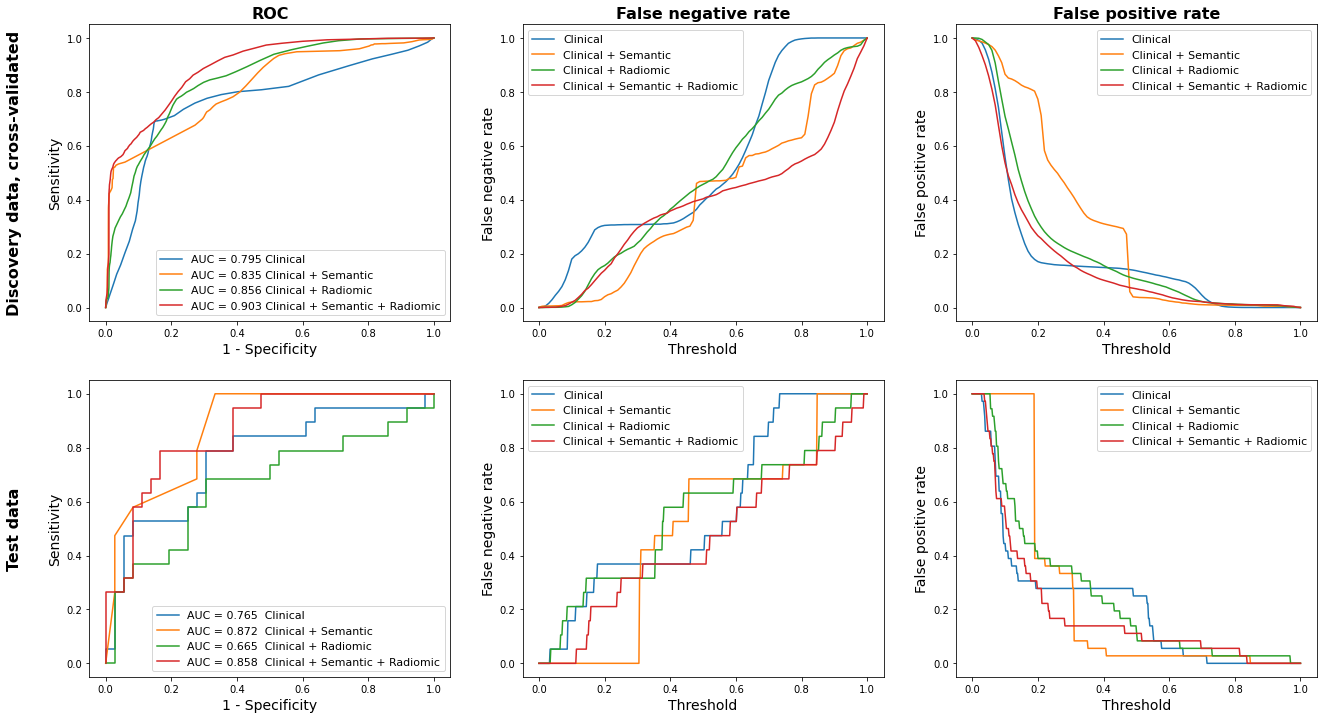

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(22,12))
ax = ax.ravel()

ax[0].plot(FPR_clin['values'], [1-x for x in FNR_clin['values']], label = 'AUC = ' + str(np.round(AUC_CV_clin,3)) + ' Clinical')
ax[0].plot(FPR_clinSeman['values'], [1-x for x in FNR_clinSeman['values']], label = 'AUC = ' + str(np.round(AUC_CV_clinSeman,3)) + ' Clinical + Semantic')
ax[0].plot(FPR_clinRad['values'], [1-x for x in FNR_clinRad['values']], label = 'AUC = ' + str(np.round(AUC_CV_clinRad,3)) + ' Clinical + Radiomic')
ax[0].plot(FPR_clinSemRad['values'], [1-x for x in FNR_clinSemRad['values']], label = 'AUC = ' + str(np.round(AUC_CV_clinSemRad,3)) + ' Clinical + Semantic + Radiomic')
ax[0].set_xlabel('1 - Specificity', fontsize=14)
ax[0].set_ylabel('Sensitivity', fontsize=14)
ax[0].set_title('ROC', fontsize=16, fontweight='bold')
ax[0].legend(fontsize=11)
ax[0].text(-0.3, 0.5, 'Discovery data, cross-validated', fontsize=16, fontweight='bold', rotation=90, verticalalignment='center')

ax[1].plot(FNR_clin['thresholds'], FNR_clin['values'], label='Clinical')
ax[1].plot(FNR_clinSeman['thresholds'], FNR_clinSeman['values'], label='Clinical + Semantic')
ax[1].plot(FNR_clinRad['thresholds'], FNR_clinRad['values'], label='Clinical + Radiomic')
ax[1].plot(FNR_clinSemRad['thresholds'], FNR_clinSemRad['values'], label='Clinical + Semantic + Radiomic')
ax[1].set_title('False negative rate', fontsize=16, fontweight='bold')
ax[1].legend(fontsize=11)
ax[1].set_xlabel('Threshold', fontsize=14)
ax[1].set_ylabel('False negative rate', fontsize=14)

ax[2].plot(FPR_clin['thresholds'], FPR_clin['values'], label='Clinical')
ax[2].plot(FPR_clinSeman['thresholds'], FPR_clinSeman['values'], label='Clinical + Semantic')
ax[2].plot(FPR_clinRad['thresholds'], FPR_clinRad['values'], label='Clinical + Radiomic')
ax[2].plot(FPR_clinSemRad['thresholds'], FPR_clinSemRad['values'], label='Clinical + Semantic + Radiomic')
ax[2].set_title('False positive rate', fontsize=16, fontweight='bold')
ax[2].legend(fontsize=11)
ax[2].set_xlabel('Threshold', fontsize=14)
ax[2].set_ylabel('False positive rate', fontsize=14)

# plot comparing ROCs
fpr_clin, tpr_clin, _ = roc_curve(yTest, y_pred_score_test_clin)
fpr_clinSeman, tpr_clinSeman, _ = roc_curve(yTest, y_pred_score_test_clinSeman)
fpr_clinRad, tpr_clinRad, _ = roc_curve(yTest, y_pred_score_test_clinRad)
fpr_clinSemRad, tpr_clinSemRad, _ = roc_curve(yTest, y_pred_score_test_clinSemRad)

thresh = np.linspace(0, 1, 500)
tnTest_clinical, fpTest_clinical, fnTest_clinical, tpTest_clinical = roc_curve_thresholds(yTest, y_pred_score_test_clin, thresh)
tnTest_semantic, fpTest_semantic, fnTest_semantic, tpTest_semantic = roc_curve_thresholds(yTest, y_pred_score_test_clinSeman, thresh)
tnTest_radiomic, fpTest_radiomic, fnTest_radiomic, tpTest_radiomic = roc_curve_thresholds(yTest, y_pred_score_test_clinRad, thresh)
tnTest_semradic, fpTest_semradic, fnTest_semradic, tpTest_semradic = roc_curve_thresholds(yTest, y_pred_score_test_clinSemRad, thresh)

ax[3].plot(fpr_clin, tpr_clin,             label='AUC = ' + str(np.round(roc_auc_score(yTest, y_pred_score_test_clin),3)) + '  Clinical')
ax[3].plot(fpr_clinSeman, tpr_clinSeman,   label='AUC = ' + str(np.round(roc_auc_score(yTest, y_pred_score_test_clinSeman),3)) + '  Clinical + Semantic')
ax[3].plot(fpr_clinRad, tpr_clinRad,       label='AUC = ' + str(np.round(roc_auc_score(yTest, y_pred_score_test_clinRad),3)) + '  Clinical + Radiomic')
ax[3].plot(fpr_clinSemRad, tpr_clinSemRad, label='AUC = ' + str(np.round(roc_auc_score(yTest, y_pred_score_test_clinSemRad),3)) + '  Clinical + Semantic + Radiomic')
ax[3].set_xlabel('1 - Specificity', fontsize=14)
ax[3].set_ylabel('Sensitivity', fontsize=14)
#ax[3].set_title('Test data', fontsize=14)
ax[3].legend(fontsize=11)
ax[3].text(-0.3, 0.5, 'Test data', fontsize=16, fontweight='bold', rotation=90, verticalalignment='center')

ax[4].plot(thresh, fnTest_clinical/(fnTest_clinical + tpTest_clinical), label='Clinical')
ax[4].plot(thresh, fnTest_semantic/(fnTest_semantic + tpTest_semantic), label='Clinical + Semantic')
ax[4].plot(thresh, fnTest_radiomic/(fnTest_radiomic + tpTest_radiomic), label='Clinical + Radiomic')
ax[4].plot(thresh, fnTest_semradic/(fnTest_semradic + tpTest_semradic), label='Clinical + Semantic + Radiomic')
#ax[4].set_title('False negative rate', fontsize=16)
ax[4].legend(fontsize=11)
ax[4].set_xlabel('Threshold', fontsize=14)
ax[4].set_ylabel('False negative rate', fontsize=14)

ax[5].plot(thresh, fpTest_clinical/(fpTest_clinical + tnTest_clinical), label='Clinical')
ax[5].plot(thresh, fpTest_semantic/(fpTest_semantic + tnTest_semantic), label='Clinical + Semantic')
ax[5].plot(thresh, fpTest_radiomic/(fpTest_radiomic + tnTest_radiomic), label='Clinical + Radiomic')
ax[5].plot(thresh, fpTest_semradic/(fpTest_semradic + tnTest_semradic), label='Clinical + Semantic + Radiomic')
#ax[5].set_title('False positive rate', fontsize=16)
ax[5].legend(fontsize=11)
ax[5].set_xlabel('Threshold', fontsize=14)
ax[5].set_ylabel('False positive rate', fontsize=14)

#figFile = os.path.join(os.path.expanduser('~'), 'Dropbox (ICR)/CLINMAG/Radiomics/ECE_Prostate_Semantic/results/Figure1.pdf')
#plt.savefig(figFile)
plt.show()